<a href="https://colab.research.google.com/github/WoobeenJeong/bioinfo1_jwb/blob/main/Project_jwb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1) Data mounting**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2) Environment setting**

In [ ]:
!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

In [ ]:
!conda install -y bedtools bioawk samtools

**3) Data loading & check**

In [5]:
%cd /content/drive/MyDrive/binfo1-work

/content/drive/MyDrive/binfo1-work


In [ ]:
!ls -al /content/drive/MyDrive/binfo1-work/

In [12]:
!md5sum /content/drive/MyDrive/binfo1-work/*

140aaf30bcb9276cc716f8699f04ddd6  /content/drive/MyDrive/binfo1-work/CLIP-35L33G.bam
f1b3336ed7e2f97d562dcc71641251bd  /content/drive/MyDrive/binfo1-work/CLIP-35L33G.bam.bai
3a2348b2eb684202fe8226b154e05aea  /content/drive/MyDrive/binfo1-work/filtered-RPF-siLuc.bam
2b5021d2ac3d4830fd963d950a2dc0b8  /content/drive/MyDrive/binfo1-work/fivepcounts-filtered-RPF-siLuc.txt
e22f2adecc2da272b1297850ac463105  /content/drive/MyDrive/binfo1-work/fivepcounts-RPF-siLuc.bed
ed47186ee44654792a8a130c695f3a22  /content/drive/MyDrive/binfo1-work/gencode-exons-containing-startcodon.bed
d54d428f5872030c4ffc43058709b896  /content/drive/MyDrive/binfo1-work/gencode.gtf
3469e3e3e018302c5488adc052fd1e21  /content/drive/MyDrive/binfo1-work/gencode-plusexon.gtf
b1c38579a9e8e0313c1508f02ce0afaf  /content/drive/MyDrive/binfo1-work/gencode-start.gtf
2386750ffd7ddd7288bb821ca018069b  /content/drive/MyDrive/binfo1-work/matches.txt
2698e6c8e30005ebc0593d3b9e9b5c58  /content/drive/MyDrive/binfo1-work/read-counts.txt
7c

**4) Background setting**

In [47]:
%cd /content/drive/MyDrive/binfo1-work
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter

/content/drive/MyDrive/binfo1-work


**5) Target region on CLIP-seq using gencode.gtf**

In [14]:
!grep -i mirlet7g gencode.gtf

chr9	ENSEMBL	gene	106056039	106056126	.	+	.	gene_id "ENSMUSG00000065440.3"; gene_type "miRNA"; gene_name "Mirlet7g"; level 3; mgi_id "MGI:2676800";
chr9	ENSEMBL	transcript	106056039	106056126	.	+	.	gene_id "ENSMUSG00000065440.3"; transcript_id "ENSMUST00000083506.3"; gene_type "miRNA"; gene_name "Mirlet7g"; transcript_type "miRNA"; transcript_name "Mirlet7g-201"; level 3; transcript_support_level "NA"; mgi_id "MGI:2676800"; tag "basic";
chr9	ENSEMBL	exon	106056039	106056126	.	+	.	gene_id "ENSMUSG00000065440.3"; transcript_id "ENSMUST00000083506.3"; gene_type "miRNA"; gene_name "Mirlet7g"; transcript_type "miRNA"; transcript_name "Mirlet7g-201"; exon_number 1; exon_id "ENSMUSE00000522665.2"; level 3; transcript_support_level "NA"; mgi_id "MGI:2676800"; tag "basic";


In [15]:
!samtools view -b -o CLIP-let7g.bam CLIP-35L33G.bam chr9:106056039-106056126
!samtools view CLIP-let7g.bam | wc -l

163


In [41]:
!samtools mpileup CLIP-let7g.bam 2>/dev/null > CLIP-let7g.pileup
!wc -l CLIP-let7g.pileup

68548 CLIP-let7g.pileup


In [51]:
!head -n 2 CLIP-let7g.pileup

chr9	106007092	N	9	^Ga^Ia^Ha^Ia^Ga^Ga^Ha^Ia^Ia	<IFIGGHII
chr9	106007093	N	9	ggggggggg	AFGIEGDII


In [52]:
!awk '$2 >= 106056039 && $2 <= 106056126 { print $0; }' CLIP-let7g.pileup > CLIP-let7g-gene.pileup
!tail -n 2 CLIP-let7g-gene.pileup

chr9	106056125	N	31	<<<<<<<<<GGGGGGGGGGGGGGGGGGGGGG	BHEIG?DIIIIIIGGE@GFIGD;GIGIIFHD
chr9	106056126	N	30	<<<<<<<<<GGGGGGGGGGGGGGGGGGGGG	BHEIG?DIIIIGHGHIGHI>G;GGGIGIHG


In [54]:
pileup = pd.read_csv('CLIP-let7g-gene.pileup', sep='\t', names=['chrom', 'pos', '_ref', 'count', 'basereads', 'quals'])
pileup.tail(n=3)

,chrom,pos,_ref,count,basereads,quals
85,chr9,106056124,N,31,<<<<<<<<<AAAAAAAAAAAAAAAAAAAAAA,BHEIG?DIIIIHIGGIGGGIG:9DDBIEGFH
86,chr9,106056125,N,31,<<<<<<<<<GGGGGGGGGGGGGGGGGGGGGG,BHEIG?DIIIIIIGGE@GFIGD;GIGIIFHD
87,chr9,106056126,N,30,<<<<<<<<<GGGGGGGGGGGGGGGGGGGGG,BHEIG?DIIIIGHGHIGHI>G;GGGIGIHG


In [55]:
max(pileup['pos']),max(pileup['pos'])-min(pileup['pos'])

(106056126, 87)

In [59]:
toremove = re.compile('[<>$*#^]')
pileup['matches'] = pileup['basereads'].apply(lambda x: toremove.sub('', x))
pileup[['chrom', 'pos', 'matches']]

,chrom,pos,matches
0,chr9,106056039,
1,chr9,106056040,
2,chr9,106056041,
3,chr9,106056042,
4,chr9,106056043,
...,...,...,...
83,chr9,106056122,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
84,chr9,106056123,CCCCCCCCCCCCCCCCCCCCCC
85,chr9,106056124,AAAAAAAAAAAAAAAAAAAAAA
86,chr9,106056125,GGGGGGGGGGGGGGGGGGGGGG


In [58]:
pileup[pileup['pos'] == 106056094].iloc[0]['matches']

'GGGGGGAAAAAAAAGGGGGAAAAAAGCCGCAGGATGAGGTGATAAGGGAGGGGTGAAGGGCGGTGAAGGGGAAAAGAGAAAGAAAAATAAAGGGGGAGTGGGAGGAAGAAGAGAATA'

**6) Make Shannon entrophy table**

In [60]:
len(np.unique(pileup['pos']))

88

In [62]:
Counter(pileup['matches'])

Counter({'': 6,
         'HTDTITGTHTHTITGTITHTHTITITHTHTGTHTGTHTHTHTITGT': 1,
         'GGGGGGGGGGGGGGGGGGGGGGG': 10,
         'AAAAAAAAAAAAAAAAAAAAAAA': 5,
         'TTTTTTTTTTTTTTTTTTTTTT': 2,
         'TTTTTTTTTTTTTTTTTTTTTTT': 7,
         'CCCCCCCCCCCCCCCCCCCCCCC': 1,
         'AAAAAAACAAAAAAAAAAAAAAA': 1,
         'GGGGGGGGGGGGGGGGGGGGGGGHGHGHGIGIGHGGGHG': 1,
         'TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT': 2,
         'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC': 1,
         'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAIAIAHAIA': 1,
         'TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT': 2,
         'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG': 1,
         'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA': 2,
         'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC': 2,
         'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAIAIAIAHA': 1,
         'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC': 3,
         'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG': 2,
         'TTTTTTTTTTTTTTTTTTTTTTTT': 1,
         'AAAAAAAAAAAAAAAAAAAAAAAAAGAGAHAGADAHAGAHAIAIAIAIAIAIAIAIAIAHAIAIAHAHA

In [65]:
pileup['base_count'] = pileup['matches'].apply(lambda x: len([c for c in x if c in ['A', 'T', 'G', 'C']]))
np.unique(pileup['base_count'])

array([  0,  21,  22,  23,  24,  28,  31,  32,  34,  36,  70,  78,  79,
       109, 117, 124, 126, 127, 129, 130, 131, 135, 136])

Shannon entropy:

H = −∑ p(i)*log2p(i)

In [83]:
pileup['nonzero'] = prob[prob!=0]
pileup['nonzero'].fillna(0, inplace=True)
pileup['shannon'] = -pileup['nonzero']*np.log2(pileup['nonzero'])
pileup['shannon'].fillna(0, inplace=True)
np.unique(pileup['shannon'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([0.        , 0.03151446, 0.03273766, 0.03394853, 0.03514762,
       0.03983528, 0.04324786, 0.04436749, 0.04658159, 0.04876377,
       0.08219769, 0.08930318, 0.09017523, 0.11490573, 0.1210924 ,
       0.12638365, 0.12787548, 0.12861816, 0.13009713, 0.13083345,
       0.13156769, 0.1344841 , 0.13520815])

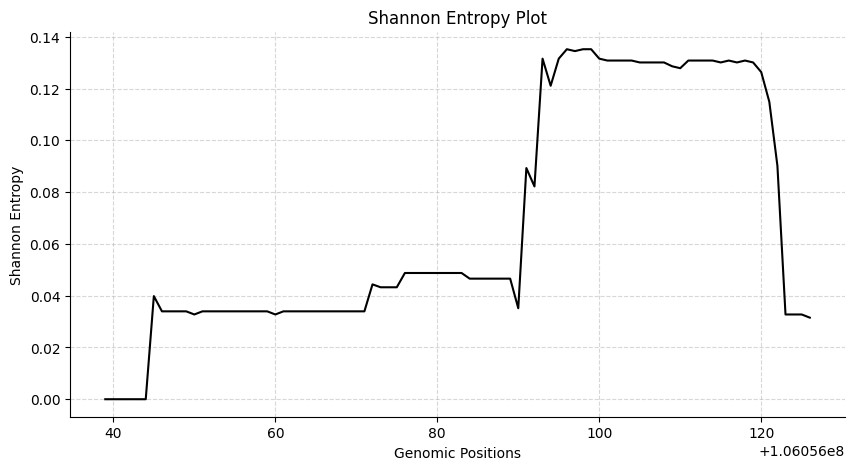

In [84]:
import matplotlib.pyplot as plt

pileup = pileup.sort_values('pos')

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(pileup['pos'], pileup['shannon'], color='black')
ax.set_xlabel('Genomic Positions')
ax.set_ylabel('Shannon Entropy')
ax.set_title('Shannon Entropy Plot')
ax.grid(True, which='both', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()